# API `Functional` de tf.keras

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thalitadru/CoursNNDL/blob/master/TFKerasFunctional.ipynb)

tf.keras est l'API haut-niveau par défaut de Tensorflow. Pour la plupart des projets, elle sera souvent suffisante pour exprimer vos modèles, avec l'avantage d'éliminer pas mal de code répétitif "boiler-plate" avec pas mal d'abstractions sur les solveurs d'optimisation (`optimisers`) et sur boucles d'entraînement et validation (`model.fit()` et `model.evaluate()`).
Il s'agit en plus d'une API bien documentée et réputée pour sa facilité de prise en main.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, losses

SEED = 0
np.random.seed(SEED)
rng = np.random.RandomState(SEED)
tf.random.get_global_generator().reset_from_seed(SEED)

## Functional API

Avec l'API fonctionnele vous peuvez creer des modèles plus complexes. Vous allez enchainner les opèrations correspondantes à chaque couche, puis fournir les tenseurs d'entree et de sortie comme paramètres pour la construction d'un `tf.keras.Model`.

### Inputs

In [2]:
img_inputs = keras.Input(shape=(32, 32, 3))

In [3]:
img_inputs.dtype

tf.float32

In [4]:
img_inputs.shape

TensorShape([None, 32, 32, 3])

#### Question

Pourquoi pensez-vous que le tenseur `img_shape` a une dimension de taille `None` ?

### Calculs intermediaires
Nous pouvons connecter des couches avec plus de liberté.

In [5]:
scale_inputs = layers.experimental.preprocessing.Rescaling(1.0/255)(img_inputs)

In [6]:
conv1 = layers.Conv2D(
    filters=16,
    kernel_size=3,
    activation="relu",
    input_shape=(32, 32, 3),
    padding="same",
    strides=2,
    kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED),
    name="conv1"
)(scale_inputs)
conv1

<KerasTensor: shape=(None, 16, 16, 16) dtype=float32 (created by layer 'conv1')>

In [7]:
conv2a = layers.Conv2D(
    filters=16,
    kernel_size=3,
    activation="relu",
    padding="same",
    kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED),
    name='conv2a'
)(conv1)
conv2a

<KerasTensor: shape=(None, 16, 16, 16) dtype=float32 (created by layer 'conv2a')>

In [8]:
conv2b = layers.Conv2D(
    filters=16,
    kernel_size=5,
    activation="relu",
    padding="same",
    kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED),
    name='conv2b'
)(conv1)
conv2b

<KerasTensor: shape=(None, 16, 16, 16) dtype=float32 (created by layer 'conv2b')>

In [9]:
conv2 = layers.Concatenate(axis=-1)([conv2a, conv2b])
conv2

<KerasTensor: shape=(None, 16, 16, 32) dtype=float32 (created by layer 'concatenate')>

In [10]:
conv3 = layers.Conv2D(
    filters=16,
    kernel_size=3,
    activation="relu",
    padding="valid",
    strides=2,
    kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED),
    name="conv3"
)(conv2)
conv3

<KerasTensor: shape=(None, 7, 7, 16) dtype=float32 (created by layer 'conv3')>

In [11]:
x = layers.Flatten()(conv3)
x

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>

In [12]:
x = layers.Dropout(0.2)(x)

In [13]:
dense1 = layers.Dense(
    units=64,
    kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED),
    name="dense1",
)(x)
dense1

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense1')>

In [14]:
dense2 = layers.Dense(
    32, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED), name="dense2"
)(dense1)
dense2

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense2')>

### Output
La dernière couche est déclaré comme les autres. Il faut penser a y mettre une taille adapté au problème. Si c'est de la classification 100 classes par exemple:

In [15]:
outputs = layers.Dense(100)(dense2)
outputs

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense')>

### Modèle

In [16]:
model2 = keras.Model(inputs=img_inputs, outputs=outputs, name="my_cnn")
model2.save_weights('init.h5')
model2

In [17]:
model2.summary()

Model: "my_cnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 16)   448         rescaling[0][0]                  
__________________________________________________________________________________________________
conv2a (Conv2D)                 (None, 16, 16, 16)   2320        conv1[0][0]                      
_____________________________________________________________________________________________

#### Visualisation

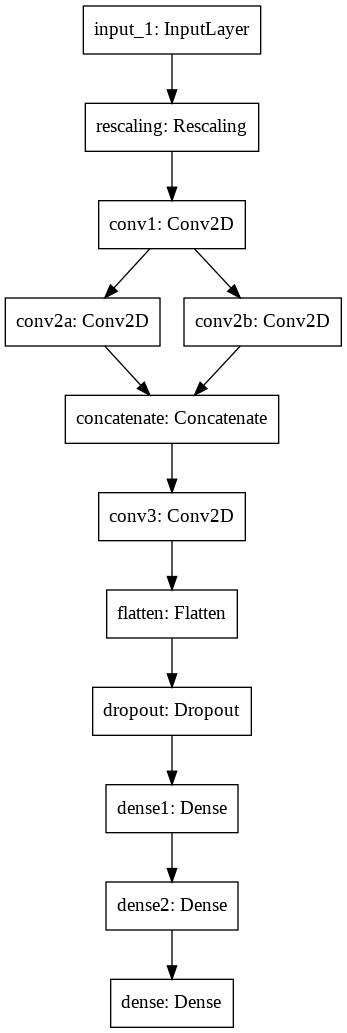

In [18]:
keras.utils.plot_model(model2)

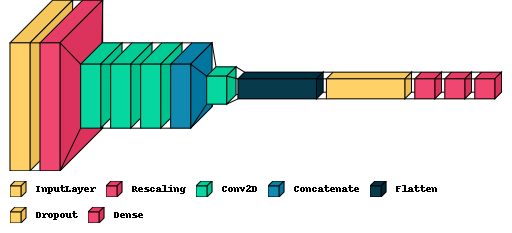

In [19]:
try:
    import visualkeras as vk
except ModuleNotFoundError:
    !pip install visualkeras
    import visualkeras as vk

vk.layered_view(model2, legend=True)

## Exemple: Classification d'images sur Cifar100

Entraînez ce modèle sur le dataset Cifar100
- Chargez les données
- Compilez le modèle
- Appelez `fit` pour lancer l'entrainement
- Affichez les courbes d'apprentissage

In [20]:
#?keras.datasets.cifar10.load_data

In [21]:
cifar10 = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

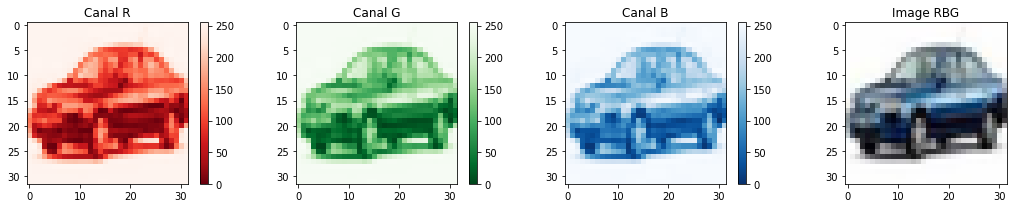

In [30]:
#@title Affichage d'une image et ses 3 canaux individuellement { display-mode: "form" }
img_id =  105# @param 
img = train_images[img_id, ...]
cmaps = ["Reds_r", "Greens_r", "Blues_r"]
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
axs[3].imshow(img.astype("uint8"))
axs[3].set_title("Image RBG")
for ch in range(3):
    ax = axs[ch]
    imgplt = ax.imshow(img[..., ch], cmap=cmaps[ch])
    ax.set_title("Canal " + cmaps[ch][0])
    fig.colorbar(imgplt, ax=ax)
plt.tight_layout()

In [31]:
# compilez le modèle avec les parametres
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = 'RMSprop'
metrics = ['accuracy']
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    min_delta=0.001,
    restore_best_weights=True,
    )
callbacks = [early_stop]
callbacks.append(keras.callbacks.ReduceLROnPlateau(verbose=1))

In [24]:
model2.compile(optimizer, loss, metrics)
model2.load_weights('init.h5')
out = model2.fit(
    train_images,
    y=train_labels,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    verbose=0,
    callbacks=callbacks,
)

Restoring model weights from the end of the best epoch.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00036: early stopping


In [25]:
#@title Déclaration de la fonction learning_curves
def learning_curves(out, **kwargs):
    metrics = out.history.keys()
    metrics = filter(lambda m: not m.startswith("val"), metrics)
    metrics = filter(lambda m: not m.startswith("lr"), metrics)
    metrics = list(metrics)
    num_metrics = len(metrics)
    fig, axs = plt.subplots(
        num_metrics,
        1,
        figsize=(15, 5 * num_metrics),
    )
    for i, metric in enumerate(metrics):
        loss = out.history[metric]
        val_loss = out.history["val_" + metric]
        epochs_range = range(1, len(loss) + 1)
        ax = axs[i]
        ax.plot(
            epochs_range,
            loss,
            marker=".",
            linestyle="dashed",
            label="Train " + metric,
            **kwargs
        )
        ax.plot(
            epochs_range,
            val_loss,
            marker=".",
            linestyle="dashed",
            label="Valid " + metric,
            **kwargs
        )
        ax.legend()
        ax.set_title(metric)
    ax.set_xlabel("epochs")
    fig.suptitle("courbes d'apprentisage x époques", fontsize="x-large")

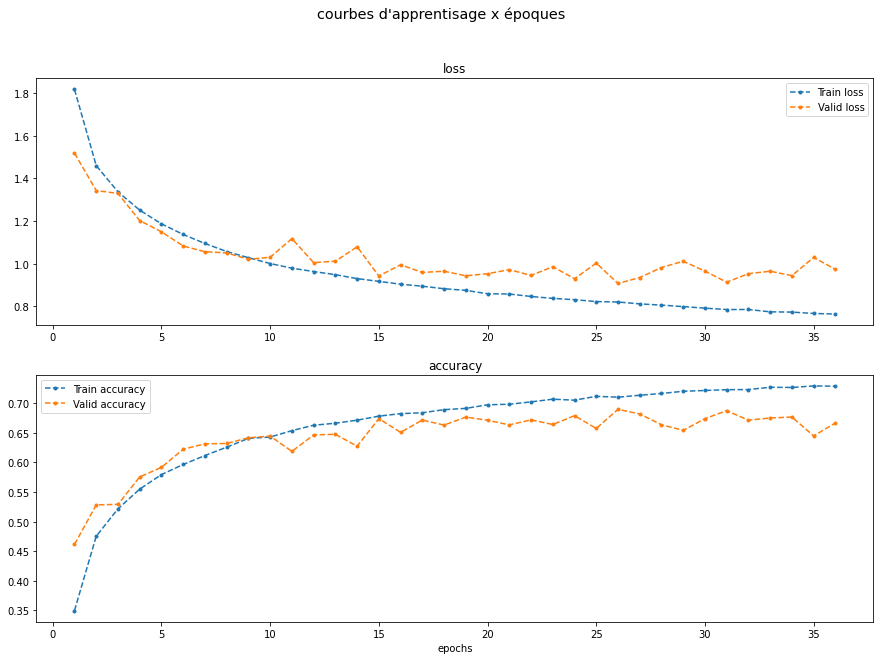

In [26]:
learning_curves(out)

In [27]:
model2.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.9326 - accuracy: 0.6699


[0.9325990080833435, 0.6699000000953674]

## Exercice : tf_flowers
Appliquez ce modèle de réseau au dataset tf_flowers du dernier notebook. N'oubliez pas d'adapter la taille des images et l'entrée du reseau entre elles.

## Avancé : API orienté-objet pour Modèles et couches custom
On peut créer un modèle personalisé en héritant de `tf.keras.Model` (voir [doc](https://www.tensorflow.org/guide/keras/custom_layers_and_models#the_model_class)). 

Il est également possible de creer des couches personalisées en héritant de `tf.keras.layers.Layer` (voir [doc](https://www.tensorflow.org/guide/keras/custom_layers_and_models#the_layer_class_the_combination_of_state_weights_and_some_computation)).

Les classes dérivés doivent implémenter une méthode `_call_(self, input)` qui compute les calculs en avant  (forward pass) du modèle, à l'aide de l'API fonctionnelle, et retourne les outputs